# Setup Code

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import Input, Model
import os
import cv2
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from ipywidgets import Text, Layout, Button
from IPython.display import display, Math, update_display
from latex2sympy2 import latex2latex
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
 
 
from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

2024-02-15 08:02:39.952513: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 08:02:40.017380: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 08:02:40.017413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 08:02:40.019237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 08:02:40.030074: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def square(image):
    w = image.width
    h = image.height
    if w<h:
        result = Image.new(image.mode, (h, h), (255,255,255))
        result.paste(image, (int((h-w)/2), 0))
        image = result
    elif h<w:
        result = Image.new(image.mode, (w, w), (255,255,255))
        result.paste(image, (0, int((w-h)/2)))
        image = result
    return image

In [3]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
 
seed_everything(42)
 
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

In [4]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
trained_model = VisionEncoderDecoderModel.from_pretrained('seq2seq_model_printed/checkpoint-'+str(1400)).to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [5]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.
 
 
    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [6]:
def get_character_bounding_boxes(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    output = cv2.connectedComponentsWithStats(
        thresh, 8, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    new_stats = []
    added = [False for i in range(len(stats))]
    threshhold = .5
    for i in range(1,len(stats)):
        if added[i]:
            continue

        (xi, yi, wi, hi, ai) = stats[i]
        for j  in range(i+1,len(stats)):
            if added[j]:
                continue

            (xj, yj, wj, hj, aj) = stats[j]
            if xi<=xj:
                if xi+wi>=xj+wj:
                    hi = max(yi+hi,yj+hj)
                    yi = min(yi,yj)
                    hi = hi-yi
                    ai += aj
                    added[j] = True
                elif xi+wi>=xj:
                    o = xi+wi-xj
                    if o/wi>threshhold or o/wj>threshhold:
                        wi = xj+wj-xi
                        hi = max(yi+hi,yj+hj)
                        yi = min(yi,yj)
                        hi = hi-yi
                        ai += aj
                        added[j] = True

            if xj<xi:
                if xj+wj>=xi+wi:
                    xi = xj
                    wi = wj
                    hi = max(yi+hi,yj+hj)
                    yi = min(yi,yj)
                    hi = hi-yi
                    ai += aj
                    added[j] = True
                elif xj+wj>=xi:
                    o = xj+wj-xi
                    if o/wi>threshhold or o/wj>threshhold:
                        wi = xj+wj-xi
                        hi = max(yi+hi,yj+hj)
                        yi = min(yi,yj)
                        hi = hi-yi
                        ai += aj
                        added[j] = True

        new_stats.append([xi, yi, wi, hi, ai])
        added[i] = True

    new_stats = sorted(new_stats, key=lambda x: x[0])
    return new_stats

def binarize_image(img, threshold=127):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding with background-foreground inversion
    binary_img = cv2.threshold(img, threshold, 1, cv2.THRESH_BINARY_INV)[1]

    return binary_img

In [7]:
mapping = {'%': 0, '*': 1, '+': 2, '-': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '[': 14, ']': 15}
reverse_mapping = {0: '/', 1: '*', 2: '+', 3: '-', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '[', 15: ']'}

In [8]:
model = load_model('./models/fine_tuned_model.keras')

2024-02-15 08:03:10.329870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17312 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-02-15 08:03:10.331722: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22994 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5
2024-02-15 08:03:10.333232: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22992 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2024-02-15 08:03:10.334262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22994 MB memory:  -> device: 3, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, comp

In [9]:
def format_input_img(img, bb):
    (x, y, w, h, a) = bb
    cropped = img[y:y+h, x:x+w]
    cropped = cv2.resize(cropped, (28, 28))
    return binarize_image(cropped)

### If want to change img path

In [10]:
images_dir = 'handwritten-full-test'
images = [f.path for f in os.scandir(images_dir)]
images

['handwritten-full-test/8+4.jpg',
 'handwritten-full-test/1+1.jpg',
 'handwritten-full-test/48-88.jpg',
 'handwritten-full-test/2x2.jpg',
 'handwritten-full-test/67+81-98+10.jpg',
 'handwritten-full-test/72_div_2.jpg',
 'handwritten-full-test/3x[2+9].jpg',
 'handwritten-full-test/123x359.jpg',
 'handwritten-full-test/14592_div_2x4-3.jpg']

# DEMO: Our Model

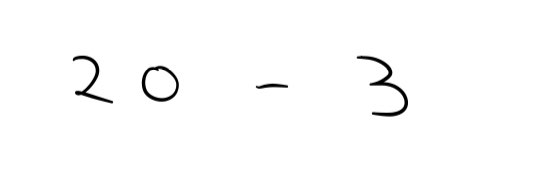

In [18]:
from PIL import Image
# Good: 0, 1, 2, 5
# img = images[6]
img = "demo-images/image0.jpg"
img = cv2.imread(img)
bbs = get_character_bounding_boxes(img)
display(Image.fromarray(img))

In [19]:
count = 0
out_str = ""
for bb in bbs:
    char = format_input_img(img, bb)
    char = char.reshape(-1, 28, 28, 1) 
    yh_test = model.predict(char).argmax(axis=1)
    out_str += reverse_mapping[yh_test[0]]
    print(reverse_mapping[yh_test[0]])
print(f"FINAL: {out_str}")

1/1 [==============================] - 0s 50ms/step
2
1/1 [==============================] - 0s 39ms/step
0
1/1 [==============================] - 0s 39ms/step
-
1/1 [==============================] - 0s 33ms/step
3
FINAL: 20-3


Text(value='20-3')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

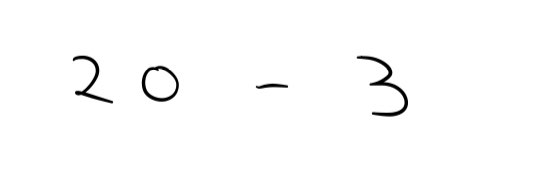

In [20]:
# Display the latex string
latex_str = out_str
text_box = Text(value=latex_str)
latex_math = Math(text_box.value)
solve_button = Button(description='Solve', layout=Layout(width='100%'))

def solve_latex(change):
    try:
        out = latex2latex(text_box.value)
        update_display(Math(out), display_id='latex_out')
    except:
        update_display("Bad Latex", display_id='latex_out')

def update_latex(change):
    update_display(Math(text_box.value), display_id='latex_in')
    solve_latex(None)

text_box.observe(update_latex, names='value')

display(text_box)
display("", display_id='latex_in')
display("", display_id='latex_out')
update_latex(None)
display(Image.fromarray(img))
print()

# DEMO: TrOCR

In [21]:
orig_img = "demo-images/image1.jpg"
orig_img = cv2.imread(orig_img)
orig_img = Image.fromarray(orig_img)
img = square(orig_img)

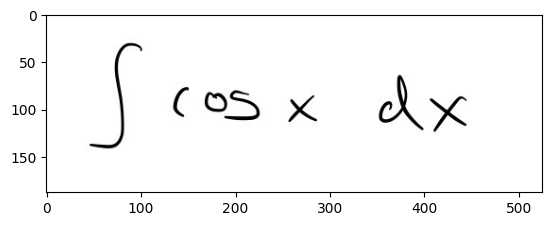

In [22]:
#TODO: Run model on img and save output into `latex_str`
plt.imshow(orig_img)

In [23]:
latex_str = ocr(img, processor, trained_model)

Text(value='$\\int \\cos x d x$')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

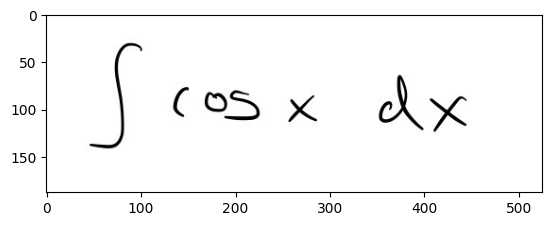

In [24]:
from ipywidgets import Text, Layout, Button
from IPython.display import display, Math, update_display
from latex2sympy2 import latex2latex

text_box = Text(value=latex_str)
latex_math = Math(text_box.value)
solve_button = Button(description='Solve', layout=Layout(width='100%'))

def solve_latex(change):
    try:
        out = latex2latex(text_box.value)
        update_display(Math(out), display_id='latex_out')
    except:
        update_display("Bad Latex", display_id='latex_out')

def update_latex(change):
    update_display(Math(text_box.value), display_id='latex_in')
    solve_latex(None)

text_box.observe(update_latex, names='value')

display(text_box, clear=True)
display("", display_id='latex_in')
display("", display_id='latex_out')
update_latex(None)
plt.imshow(orig_img)
print()